### Assigment 1
Yorick Juffer \
s1993623

**Libraries**

In [302]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Noise**

In [303]:
def noise(s):
    rand = random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)

**Time to Pulses**

In [304]:
def time_to_pulses(time, t_0 = 0.1, a = 1.02, b = 0.015, add_noise = True):
    
    pulses = 0
    pulse_duration = t_0
    
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
        
    return pulses

**Pulses to Time**

In [305]:
def pulses_to_time(pulses, t_0 = 0.1, a = 1.02, b = 0.015, add_noise = True):
    
    time = 0
    pulse_duration = t_0
    
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    
    return time

**Reaction Time Experiment**

<AxesSubplot: ylabel='average'>

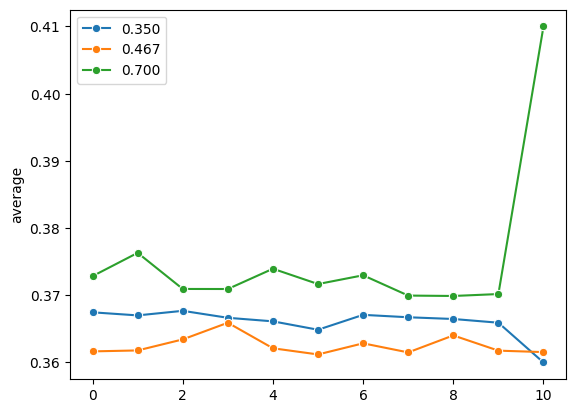

In [459]:
def reaction(condition, participants = 26, training = 7, trials = 11):
    results = pd.DataFrame(index=range(trials), columns=range(participants))

    # keeps track of the original condition time
    condition_saved = condition

    for participant in range(participants):

        # Reset variables
        memory = 0
        condition = condition_saved       

        # train
        for i in range(training):
            memory += time_to_pulses(condition)
        memory = memory / training
        
        # trials
        for trial in range(trials):

            reaction_time = 0.410

            if(trial == trials - 1):
                condition_saved = condition
                condition =  0.467

            # the difference between the observed stimulus time, and the expected timing based on memory. 
            difference = condition - pulses_to_time(memory)

            if(difference >= 0.05):
                reaction_time =  reaction_time - 0.05
            elif(difference <= 0):
                reaction_time =  reaction_time
            else: 
                reaction_time =  reaction_time - difference

            # continues to learn. It's divided by 2.01 to counteract a bias introduced by the time_to_pulses function.
            # the bias causes RT to slowly creep up. 
            # to view this bias, set the division = 2, and trials = 111
            memory = (memory + time_to_pulses(condition))/2.01

            results.at[trial, participant] = reaction_time
            results["average"] = results.mean(axis=1)

    return results["average"]



result_350 = reaction(0.350)
result_467 = reaction(0.467)
result_700 = reaction(0.700)

sns.lineplot(data=result_350, label="0.350", marker="o")
sns.lineplot(data=result_467, label="0.467", marker="o")
sns.lineplot(data=result_700, label="0.700", marker="o")
